In [31]:
import pandas as pd
from matplotlib import pyplot as plt
from metrics import AF, min_ACC, WC_ACC, current_accuracy, previous_accuracy

In [32]:
accuracies = {
    #"naive": pd.read_csv("data/naive_subsampling_25.csv"),
    #"er_10": pd.read_csv("data/er_subsampling_25_mem_size_500_batch_size_mem_10.csv"),
    #"er_20": pd.read_csv("data/er_subsampling_25_mem_size_500_batch_size_mem_20.csv"),
    #"lwf": pd.read_csv("data/lwf_subsampling_25_alpha_1_temperature_2.csv"),
    #"er_lwf_10": pd.read_csv("data/er_lwf_subsampling_25_mem_size_500_batch_size_mem_10_alpha_1_temperature_2.csv"),
    #"er_lwf_20": pd.read_csv("data/er_lwf_subsampling_25_mem_size_500_batch_size_mem_20_alpha_1_temperature_2.csv"),
    #"agem": pd.read_csv("data/agem_subsampling_25_mem_size_500_sample_size_200.csv"),
    "CWR_no_freeze": pd.read_csv("data/cwr_subsampling_25_no_freeze.csv"),
    "CWR": pd.read_csv("data/cwr_subsampling_25_yes_freeze.csv")
}

In [33]:
steps_per_experience = 50
n_experiences = 6

In [34]:
min_acc = {strategy: min_ACC(acc, steps_per_experience, n_experiences) for strategy, acc in accuracies.items()}
wc_acc = {strategy: WC_ACC(acc, steps_per_experience, n_experiences) for strategy, acc in accuracies.items()}
af = {strategy: AF(acc, steps_per_experience, n_experiences) for strategy, acc in accuracies.items()}
curr_acc = {strategy: current_accuracy(acc, steps_per_experience, n_experiences) for strategy, acc in accuracies.items()}
prev_acc = {strategy: previous_accuracy(acc, steps_per_experience, n_experiences) for strategy, acc in accuracies.items()}

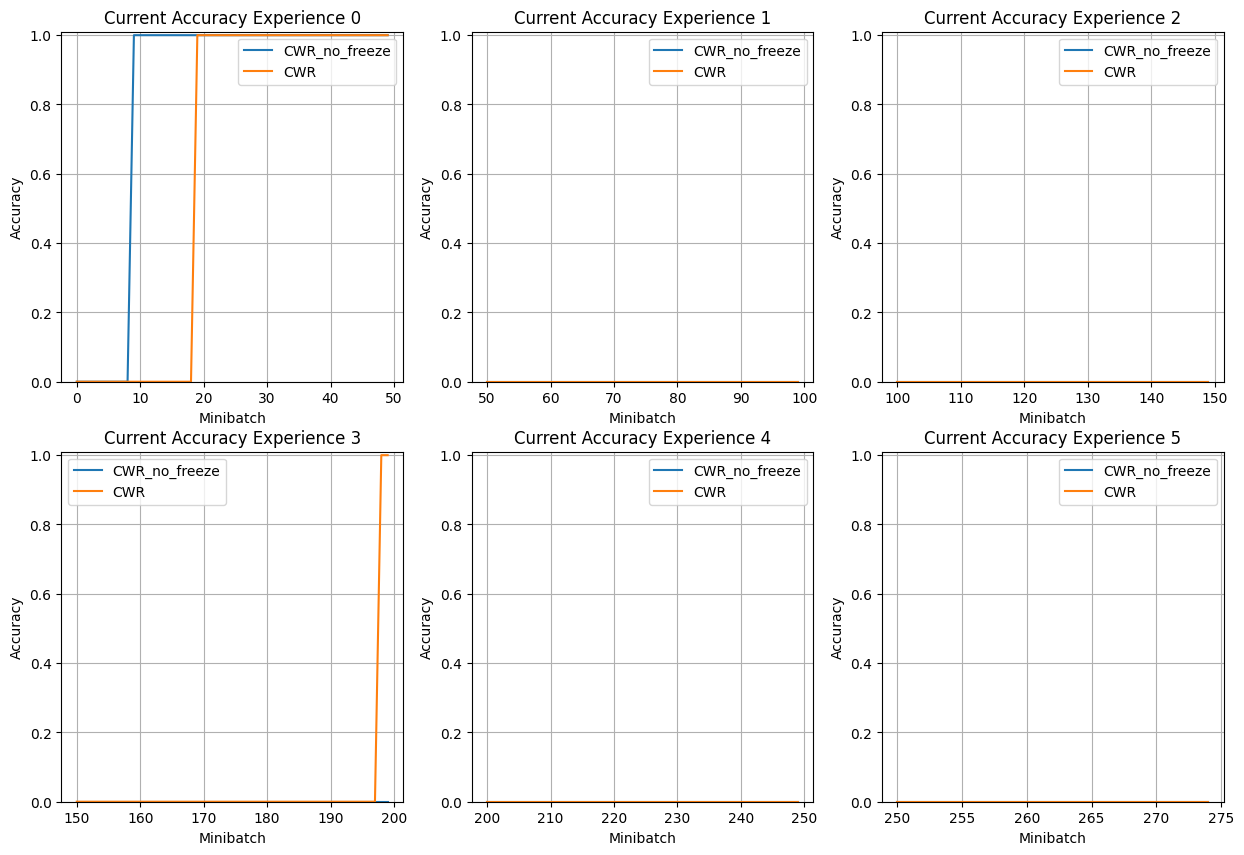

In [35]:
"""
#### CURRENT EXPERIENCE ACCURACY ####

Plot the Accuracy on the current experience after each minibatch (training step).
In each of the 6 experiences we have the accuracy for every CL strategy. 
Notice that each experience consists of 50 steps (exp_1 from 0 to 49, exp_2 from 50 to 99...),
except for the last experience that consists of 25 steps (250 samples coming from only 1 class). 
"""
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
for exp in range(n_experiences):
    for strategy, metric in curr_acc.items():
        axs[exp // 3, exp % 3].plot(metric[f"accuracy_task_{exp}"], label=strategy)
    axs[exp // 3, exp % 3].set(xlabel="Minibatch", ylabel="Accuracy")
    axs[exp // 3, exp % 3].set_ylim((0, 1.01))
    axs[exp // 3, exp % 3].set_title(f'Current Accuracy Experience {exp}')
    axs[exp // 3, exp % 3].legend()
    axs[exp // 3, exp % 3].grid()
fig.savefig(f"images/current_accuracies_CWR.png")

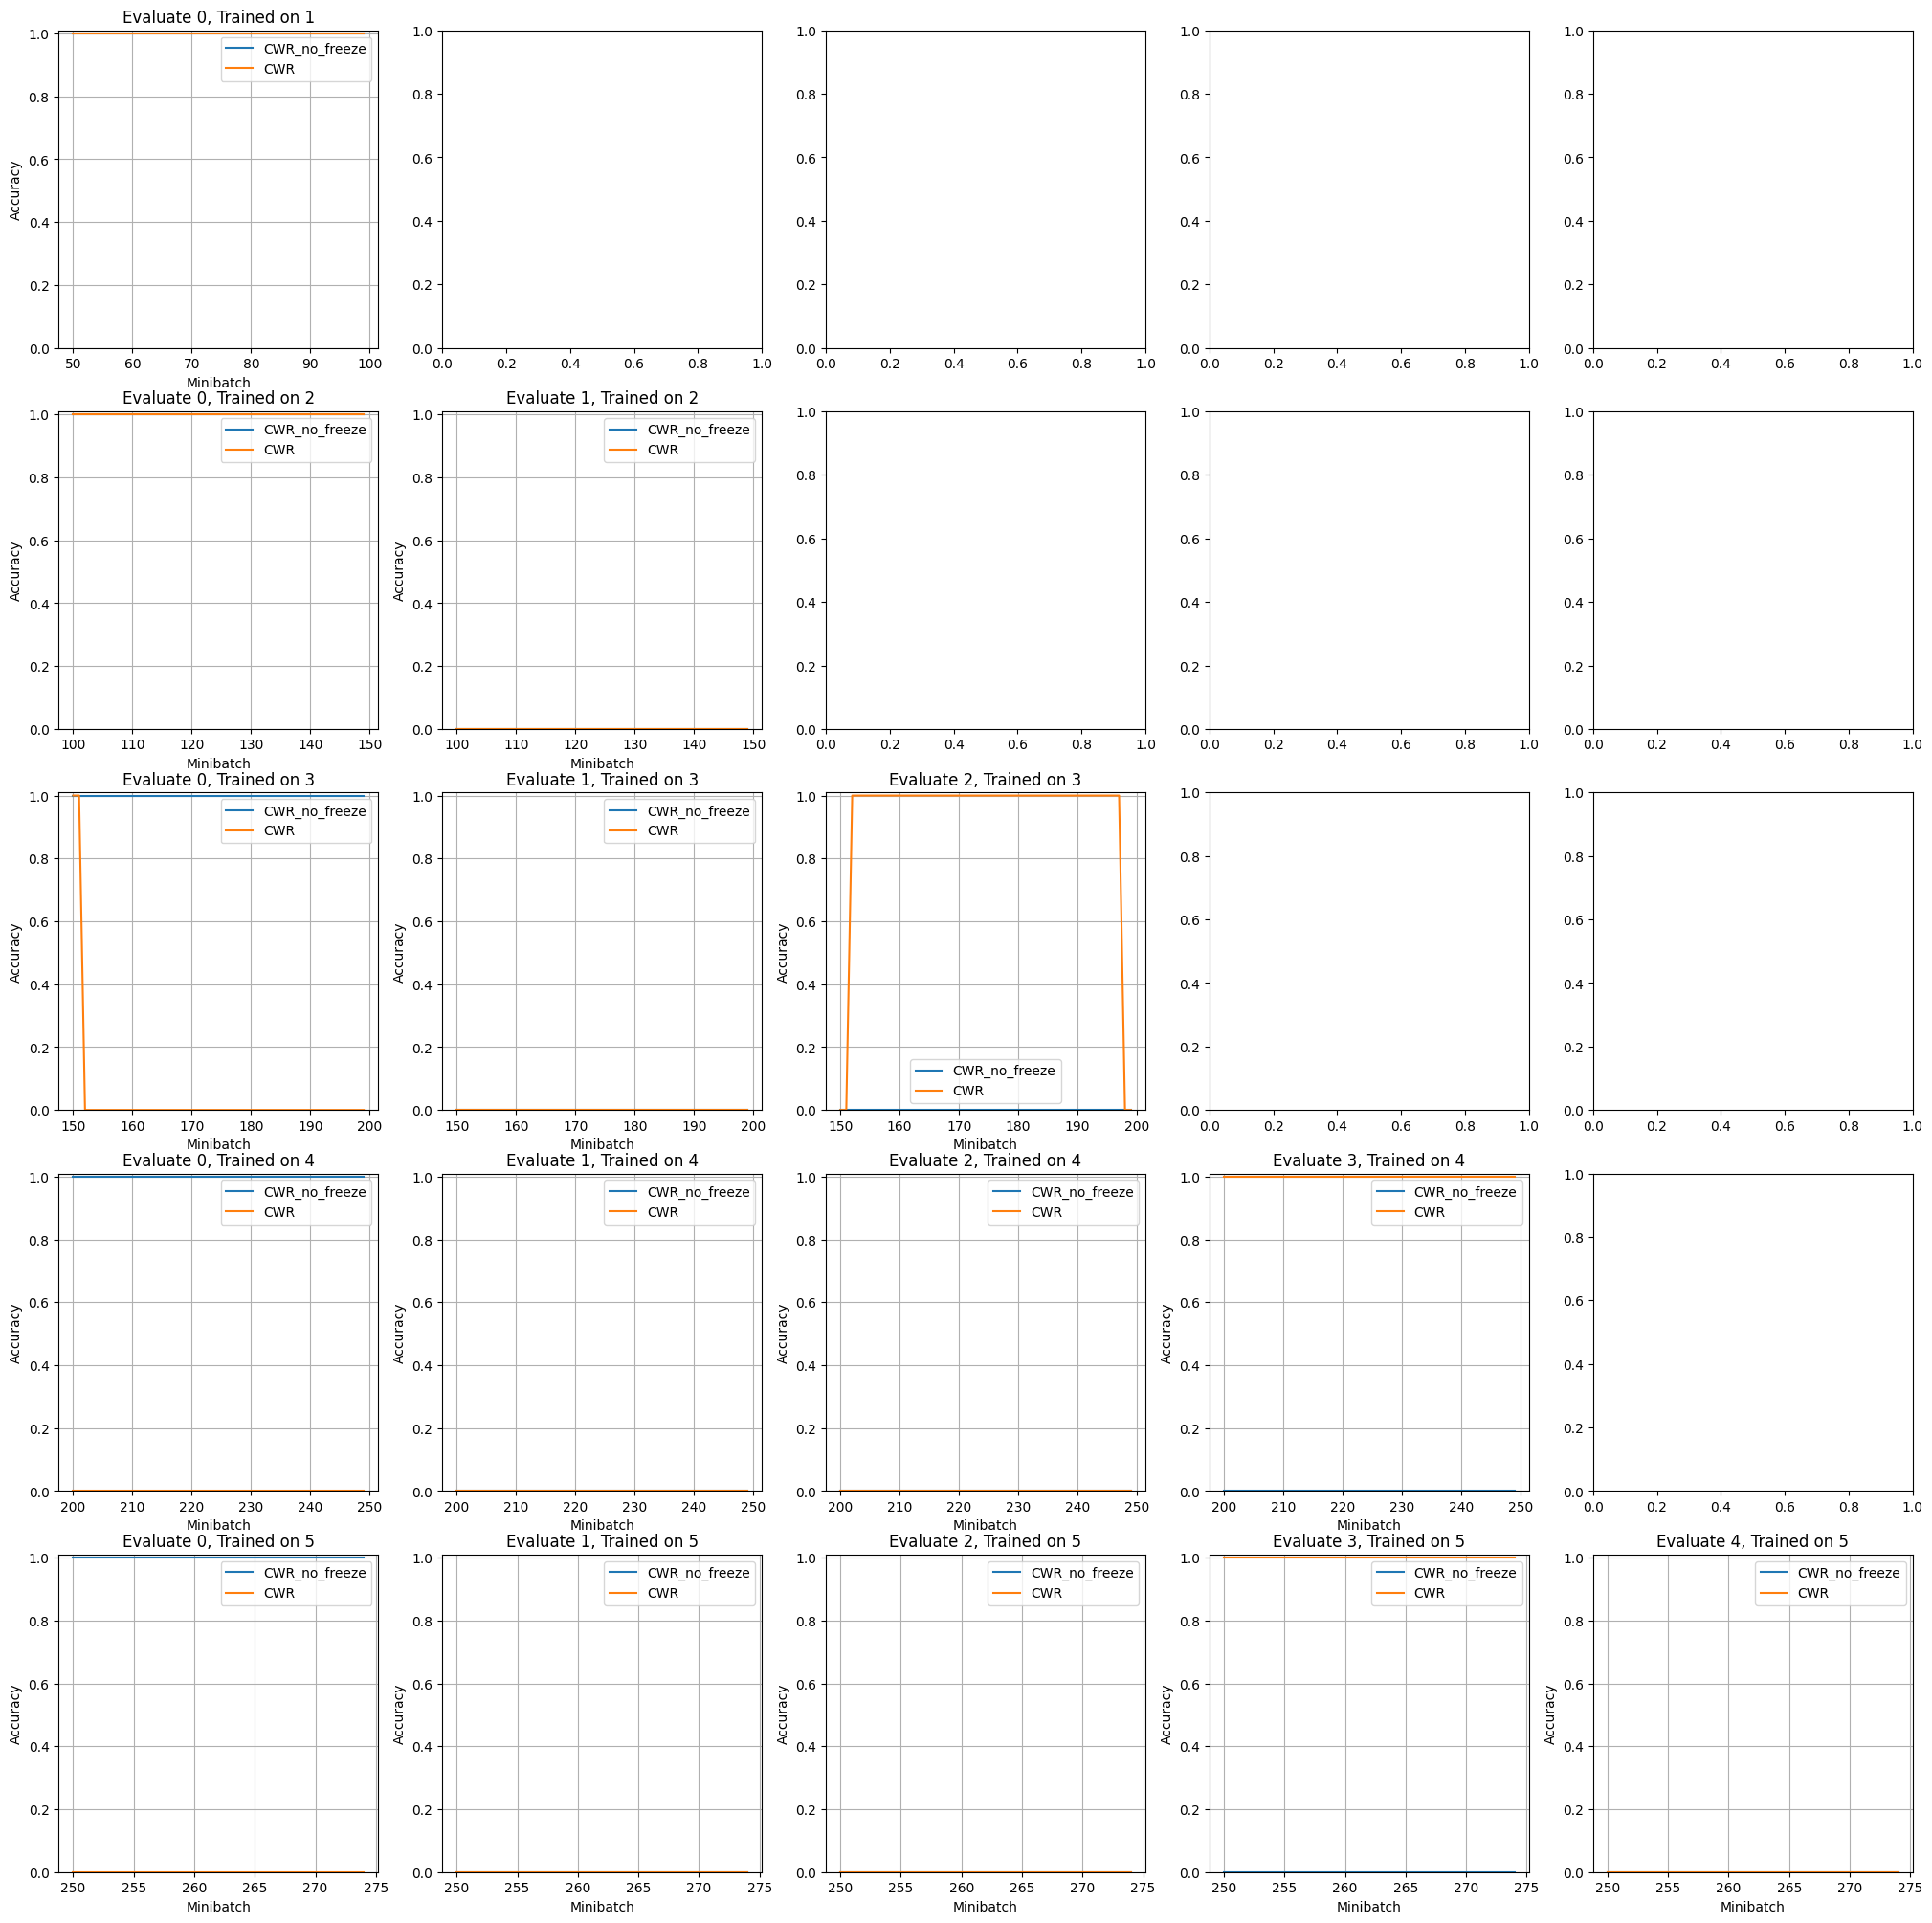

In [36]:
"""
#### PREVIOUS EXPERIENCE ACCURACY ####

Plot the Accuracy on the past experiences after each minibatch (training step).
The plot is a 5x5 matrix: since Experience 0 does not have any previous experience, 
we don't have any plot for it. 
The matrix plot must be read like this: 
(Row i, Column j): Accuracy of the model after each minibatch when the model is trained
                   on experience i and evaluated on experience j.  
Clearly the matrix is lower triangular, since for every j > i the values are missing. 
In each plot we compare in different colours every CL strategy.
Notive that the plot (4,4) has only 25 minibatches since it is the last experience.
"""
fig, axs = plt.subplots(n_experiences - 1, n_experiences - 1)
fig.set_figheight(25)
fig.set_figwidth(25)
for exp in range(1, n_experiences):
    for prev_exp in range(exp):
        for strategy, metric in prev_acc.items():
            axs[exp - 1, prev_exp].plot(metric[f"accuracies_exp_{exp}"][f"accuracy_task_{prev_exp}"], label=strategy)
        axs[exp - 1, prev_exp].set(xlabel="Minibatch", ylabel="Accuracy")
        axs[exp - 1, prev_exp].set_ylim((0, 1.01))
        axs[exp - 1, prev_exp].set_title(f'Evaluate {prev_exp}, Trained on {exp}')
        axs[exp - 1, prev_exp].legend()
        axs[exp - 1, prev_exp].grid()
fig.savefig(f"images/past_accuracies_CWR.png")

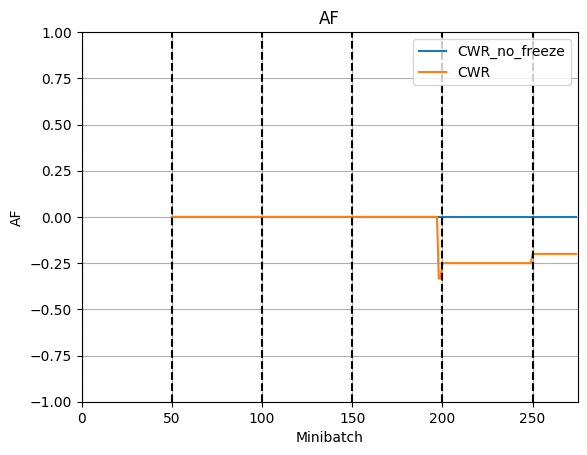

In [37]:
"""
#### AVERAGE FORGETTING ####

Plot the Average Forgetting metric obtained for every training step. 
For every step we have the AF for every CL strategy. 
AF is defined for experiences (1-5), since for experience 0 there are no previous experiences. 
Each experience is delimited by a black dashed line, and we have 50 AF values for every experience
except for the last one, that has only 25 values.
"""
plt.title("AF")
for strategy, metric in af.items():
    plt.plot(metric, label=strategy)
plt.vlines(
    range(0, n_experiences * steps_per_experience, steps_per_experience),
    ymax=1,
    ymin=-1,
    linestyles="dashed",
    colors="k"
)
plt.ylim((-1, 1))
plt.xlim((0, steps_per_experience * (n_experiences - .5)))
plt.xlabel("Minibatch")
plt.ylabel("AF")
plt.legend()
plt.grid()
plt.savefig(f"images/AF_CWR.png")
plt.show()

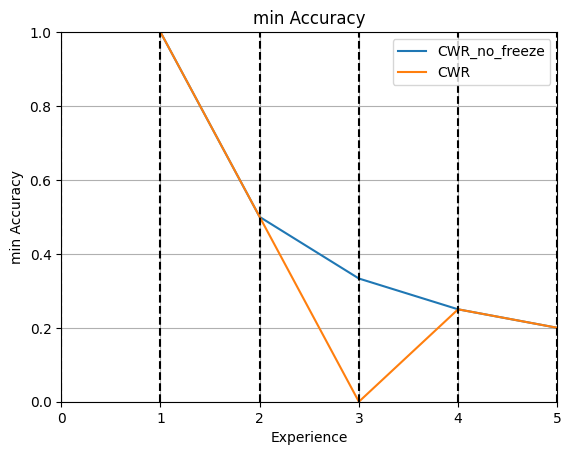

In [38]:
"""
#### min-ACC ####

Plot the Minimum Accuracy metric obtained at the end of every experience.
In each experience we have the min-ACC for every CL strategy. 
We have a value for min-ACC for experiences (1-5), since for experience 0 there are no previous experiences. 
Each experience is delimited by a black dashed line.
"""
plt.title("min Accuracy")
for strategy, metric in min_acc.items():
    plt.plot(metric, label=strategy)
plt.vlines(
    range(0, n_experiences),
    ymax=1,
    ymin=0,
    linestyles="dashed",
    colors="k"
)
plt.ylim((0, 1))
plt.xlim((0, n_experiences-1))
plt.xlabel("Experience")
plt.ylabel("min Accuracy")
plt.grid()
plt.legend()
plt.savefig(f"images/min_ACC_CWR.png")
plt.show()

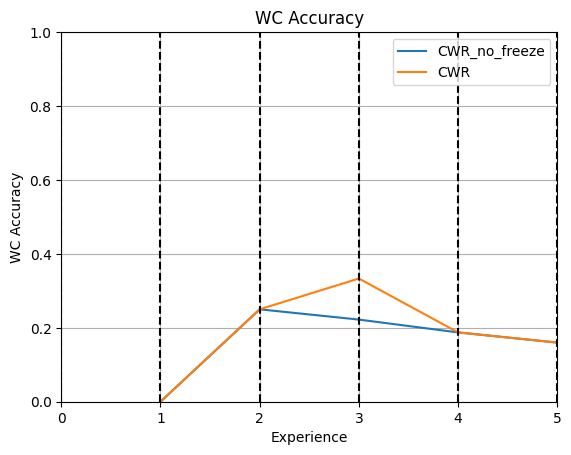

In [39]:
"""
#### WC-ACC ####

Plot the Worst Case Accuracy metric obtained at the end of every experience.
In each experience we have the WC-ACC for every CL strategy. 
We have a value for WC-ACC for experiences (1-5), since for experience 0 there are no previous experiences. 
Each experience is delimited by a black dashed line.
"""
plt.title("WC Accuracy")
for strategy, metric in wc_acc.items():
    plt.plot(metric, label=strategy)
plt.vlines(
    range(0, n_experiences),
    ymax=1,
    ymin=0,
    linestyles="dashed",
    colors="k"
)
plt.ylim((0, 1))
plt.xlim((0, n_experiences-1))
plt.xlabel("Experience")
plt.ylabel("WC Accuracy")
plt.grid()
plt.legend()
plt.savefig(f"images/WC_ACC_CWR.png")
plt.show()